In [3]:
#Importing required packages
import numpy as np
import matplotlib.pyplot as plt
from springrank import SpringRank
import polars as pl
import networkx as nx
from src import rank_swirl #this will only work if your ipynb file lives outside of the code folder
import io 
from PIL import Image
import cairosvg 
from adjustText import adjust_text

In [4]:
#read in df
df = pl.read_csv("data/aggXquarter.txt", separator = "\t")

#filter dfs by group + quarter
df_q1_g1 = df.filter(pl.col("study.quarter") == 1).filter(pl.col("group") == "G1")
df_q1_g2 = df.filter(pl.col("study.quarter") == 1).filter(pl.col("group") == "G2")
df_q2_g1 = df.filter(pl.col("study.quarter") == 2).filter(pl.col("group") == "G1")
df_q2_g2 = df.filter(pl.col("study.quarter") == 2).filter(pl.col("group") == "G2")
df_q3_g1 = df.filter(pl.col("study.quarter") == 3).filter(pl.col("group") == "G1")
df_q3_g2 = df.filter(pl.col("study.quarter") == 3).filter(pl.col("group") == "G2")
df_q4_g1 = df.filter(pl.col("study.quarter") == 4).filter(pl.col("group") == "G1")
df_q4_g2 = df.filter(pl.col("study.quarter") == 4).filter(pl.col("group") == "G2")

#create list / dictionary to filter by group + quarter (tuple) 
df_dict = {"Q1G1": df_q1_g1, "Q2G1": df_q2_g1, "Q3G1":df_q3_g1, "Q4G1":df_q4_g1, "Q1G2": df_q1_g2, "Q2G2": df_q2_g2, "Q3G2":df_q3_g2,"Q4G2":df_q4_g2}

In [5]:
#build dictionaries of graphs, adjacency matrices, and spring ranks, trying to make sure the nodes stay in the same spot
#sometimes this only works after you restart the kernel
#this should probably only be run once for results

#create empty dictionaries
G_dict = {}
A_dict = {}
S_dict = {}
rank_dict = {}

#loop through each group/quarter
for name in df_dict: 
    G = nx.DiGraph() #for each, create a network
    G.add_weighted_edges_from(df_dict[name]["actor", "target","number.wins"].rows()) #add edges
    nodes = list(G.nodes()) #add nodes
    node_dict = {i: n for i, n in enumerate(G.nodes())} #make sure we know which node is which
    A = nx.to_numpy_array(G, nodelist = nodes) #create an adjacency matrix
    A_dict[name] = A #store the adjacency matrix in our dictionary
    G_dict[name] = G #store the graph in our dictionary
    model = SpringRank(alpha = 0.1) #create a spring rank model
    model.fit(A) #apply it to our adjacency matrix
    S = model.ranks #store this group/quarter's ranking under S
    scaled_ranks = model.get_rescaled_ranks(0.75) 
    S_dict[name] = scaled_ranks #store the normalized rankings in the dictionary
    rank_dict[name] = {node_dict[i]: float(scaled_ranks[i]) for i in range(len(scaled_ranks))} #use the node dictionary to store parakeet ids with their ranks



In [6]:
#standard deviations
#create empty dictionaries
mean_dict = {}
stdev_dict = {}
for name in S_dict: #loop through all dfs
    mean = sum(S_dict[name])/len(S_dict[name]) #
    mean_dict[name] = mean
    stdev = np.std(S_dict[name])
    stdev_dict[name] = stdev


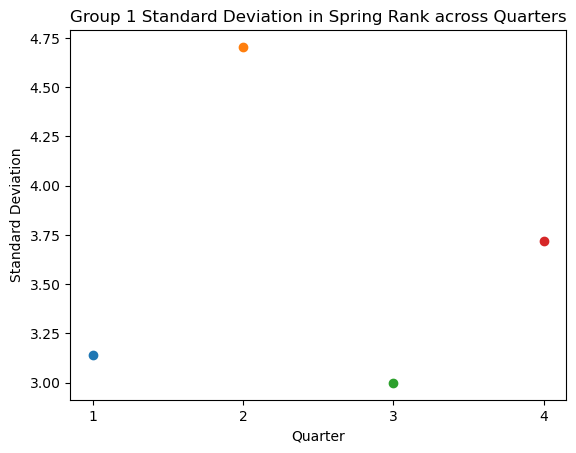

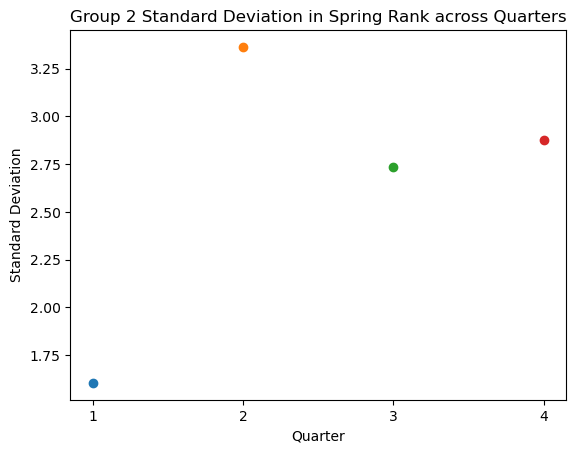

In [8]:
#plot standard deviations of Spring Rank over time
quarter_names = sorted(S_dict.keys())
group_1 = [name for name in quarter_names if name.endswith("G1")]
group_2 = [name for name in quarter_names if name.endswith("G2")]
#plot rank ranges 
k = 1
for name in group_1: 
    plt.scatter(k,stdev_dict[name])
    k = k + 1
    plt.title("Group 1 Standard Deviation in Spring Rank across Quarters")
    plt.xticks([1,2,3,4])
    #plt.ylim((0.2,0.3))
    plt.xlabel("Quarter")
    plt.ylabel("Standard Deviation")
    
plt.show()
k = 1
for name in group_2:
    plt.scatter(k, stdev_dict[name])
    k = k + 1
    plt.title("Group 2 Standard Deviation in Spring Rank across Quarters")
    plt.xticks([1,2,3,4])
    #plt.ylim((0.2,0.3))
    plt.xlabel("Quarter")
    plt.ylabel("Standard Deviation")
plt.show()

In [ ]:
#calculate measures of centrality
#create empty dictionaries
eigen_dict = {}
betw_dict = {}
close_dict = {}
#cycle through all data frames 
for name in df_dict: 
    #calcluate centrality of each node of each group of each quarter
    ec = nx.eigenvector_centrality(G_dict[name], weight = "number.wins")
    bc = nx.betweenness_centrality(G_dict[name], weight = "number.wins")
    #store centrality in the dictionaries
    eigen_dict[name] = ec
    betw_dict[name] = bc

In [ ]:
#sort centralities and examine (this is how I created the table)
print("EIGENVECTOR")
for name in df_dict: 
    print(f"sorted eigenvector centrality for {name} is {sorted(eigen_dict[name].items(), key = lambda x: x[1], reverse = True)[:5]}")
print("BETWEENNESS")
for name in df_dict:
    print(f"sorted betweenness centrality for {name} is {sorted(betw_dict[name].items(), key = lambda x: x[1], reverse = True)[:5]}")
print("SPRING RANK")
for name in df_dict: 
    print(f"sorted spring rank for {name} is {sorted(rank_dict[name].items(), key = lambda x: x[1], reverse = True)[:5]}")

EIGENVECTOR
sorted eigenvector centrality for Q1G1 is [('rbr', 0.4342407610048324), ('rnb', 0.4067955699825609), ('grb', 0.38908713175963877), ('brr', 0.32170624930813113), ('gpn', 0.29754899961464076)]
sorted eigenvector centrality for Q2G1 is [('rgn', 0.47528071258568816), ('grg', 0.4490247609438642), ('ggg', 0.34939198718998754), ('rbr', 0.3312720758814444), ('oon', 0.27594856950250873)]
sorted eigenvector centrality for Q3G1 is [('rbr', 0.40159046732489884), ('rng', 0.39630733913113764), ('grg', 0.37946606275874445), ('rgn', 0.33913862223678487), ('bbb', 0.31706253549453695)]
sorted eigenvector centrality for Q4G1 is [('rng', 0.4692457760467981), ('rgn', 0.34144450386800895), ('rnb', 0.3260316038044032), ('grr', 0.3171541348600139), ('gpn', 0.2992167584422866)]
sorted eigenvector centrality for Q1G2 is [('bnr', 0.3240285123120782), ('nnr', 0.29829859495683625), ('gnn', 0.29200694946344463), ('nbb', 0.28590958373640124), ('nrg', 0.2534004533298175)]
sorted eigenvector centrality for

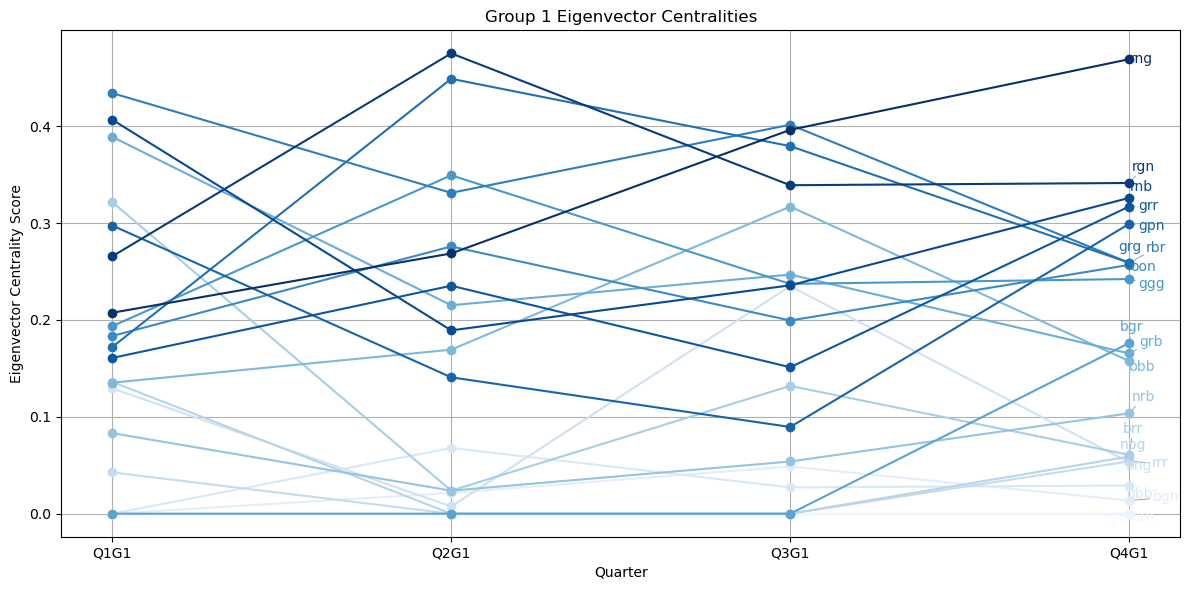

In [11]:
#plot centrality vs. rank
#plot eigenvector centrality group 1
#separate keys and values for each group, so that data can be structured group:quarter:node:rank
keys = sorted(df_dict.keys())
group_1_keys = [name for name in keys if name.endswith("G1")]
group_2_keys = [name for name in keys if name.endswith("G2")]
group_1_values = [eigen_dict[k] for k in group_1_keys]
group_2_values = [eigen_dict[k] for k in group_2_keys]
group_1_nodes = list(group_1_values[0].keys())
group_2_nodes = list(group_2_values[0].keys())
#sort by final ranking
final_key = group_1_keys[-1]
sorted_nodes = sorted(group_1_nodes, key = lambda n: eigen_dict[final_key][n], reverse = False)

plt.figure(figsize=(12,6))
texts = []
#color
colormap = plt.cm.Blues #Dr. Landry code to spectrum color it
colors = colormap(np.linspace(0, 1, len(group_1_nodes)))
for i, node in enumerate(sorted_nodes):
    color = colors[i]
    y = [eigen_dict[k][node] for k in group_1_keys] 
    line, = plt.plot(group_1_keys, y, color = color, marker = 'o', label = f"Index {node}")
    txt = plt.text(group_1_keys[-1], y[-1], f"{node}", fontsize=10, va = 'center', ha = 'left', color = line.get_color())
    texts.append(txt)
plt.xlabel("Quarter")
plt.ylabel("Eigenvector Centrality Score")
plt.title("Group 1 Eigenvector Centralities")
plt.grid(True)
plt.tight_layout()
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops = dict(arrowstyle='-', color = 'gray', lw=0.5))
plt.show()
    

1 [0.36247569 0.37676978]
2 [-0.24647373  0.97353205]


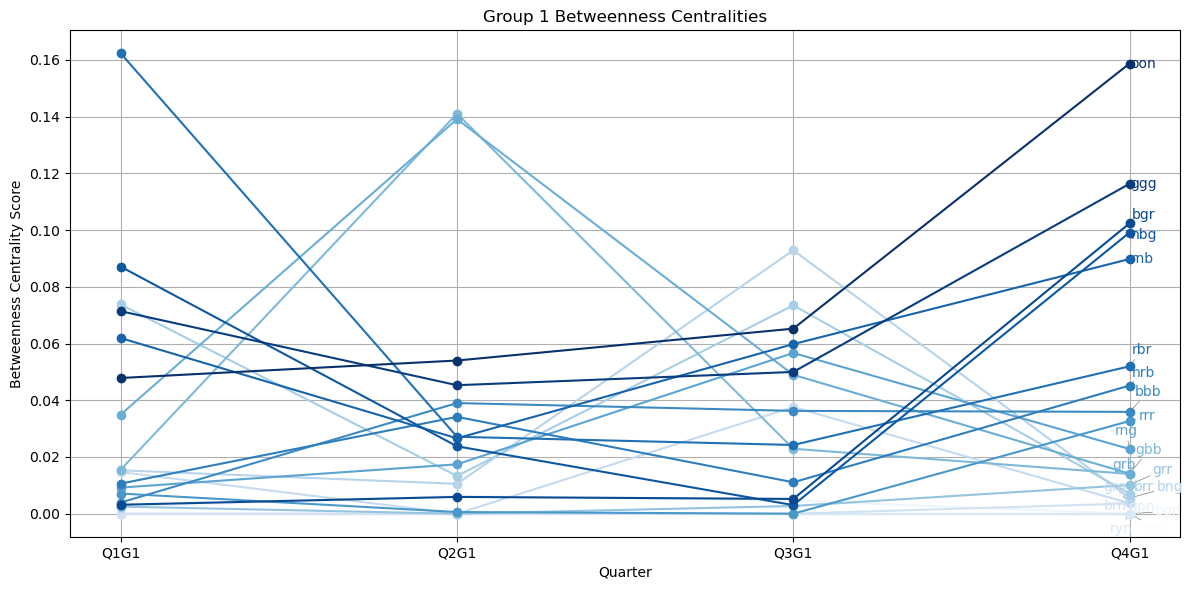

In [12]:
#plot betweenness centrality group 1
keys = sorted(df_dict.keys())
group_1_keys = [name for name in keys if name.endswith("G1")]
group_2_keys = [name for name in keys if name.endswith("G2")]
group_1_values = [betw_dict[k] for k in group_1_keys]
group_2_values = [betw_dict[k] for k in group_2_keys]
group_1_nodes = list(group_1_values[0].keys())
group_2_nodes = list(group_2_values[0].keys())
#trying to sort by final ranking
final_key = group_1_keys[-1]
sorted_nodes = sorted(group_1_nodes, key = lambda n: betw_dict[final_key][n], reverse = False)

#color
colormap = plt.cm.Blues #Dr. Landry code to spectrum color it
colors = colormap(np.linspace(0, 1, len(group_1_nodes)))

#plot
plt.figure(figsize=(12,6))
texts = []
for i, node in enumerate(sorted_nodes):
    color = colors[i]
    y = [betw_dict[k][node] for k in group_1_keys] 
    line, = plt.plot(group_1_keys, y, marker = 'o', color = color, label = f"Index {node}")
    txt = plt.text(group_1_keys[-1], y[-1], f"{node}", fontsize=10, va = 'center', ha = 'left', color = line.get_color())
    texts.append(txt)
plt.xlabel("Quarter")
plt.ylabel("Betweenness Centrality Score")
plt.title("Group 1 Betweenness Centralities")
plt.grid(True)
plt.tight_layout()
adjust_text(texts, only_move={'points':'y', 'texts':'y'}, arrowprops = dict(arrowstyle='-', color = 'gray', lw=0.5))
plt.show()

In [13]:
#calculate rank ranges 
ranges = {}
for S in S_dict: 
    #print(S_dict[S])
    high_rank = np.max(S_dict[S])
    low_rank = np.min(S_dict[S])
    range = high_rank - low_rank
    ranges[S] = range
print(ranges)


{'Q1G1': np.float64(11.239955469667482), 'Q2G1': np.float64(18.273657925897243), 'Q3G1': np.float64(11.516081377505108), 'Q4G1': np.float64(14.978636094961814), 'Q1G2': np.float64(7.013514427154435), 'Q2G2': np.float64(11.92268922581519), 'Q3G2': np.float64(10.561893240833449), 'Q4G2': np.float64(9.86211119782051)}


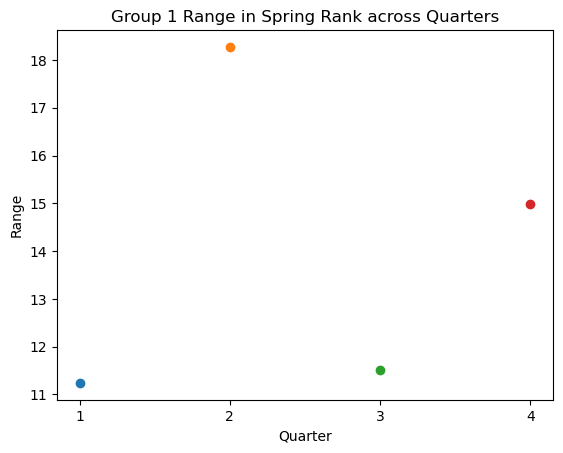

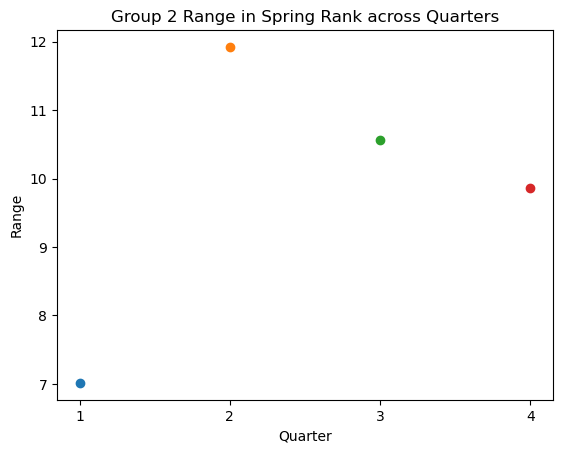

In [14]:
#plot ranges of Spring Rank over time
quarter_names = sorted(S_dict.keys())
group_1 = [name for name in quarter_names if name.endswith("G1")]
group_2 = [name for name in quarter_names if name.endswith("G2")]
#plot rank ranges 
k = 1
for name in group_1: 
    plt.scatter(k,ranges[name])
    k = k + 1
    plt.title("Group 1 Range in Spring Rank across Quarters")
    plt.xticks([1,2,3,4])
    plt.xlabel("Quarter")
    plt.ylabel("Range")
    
plt.show()
k = 1
for name in group_2:
    plt.scatter(k, ranges[name])
    k = k + 1
    plt.title("Group 2 Range in Spring Rank across Quarters")
    plt.xticks([1,2,3,4])
    plt.xlabel("Quarter")
    plt.ylabel("Range")
plt.show()


In [ ]:
del range #make sure your range is right if the above is not working, bc you call something else range

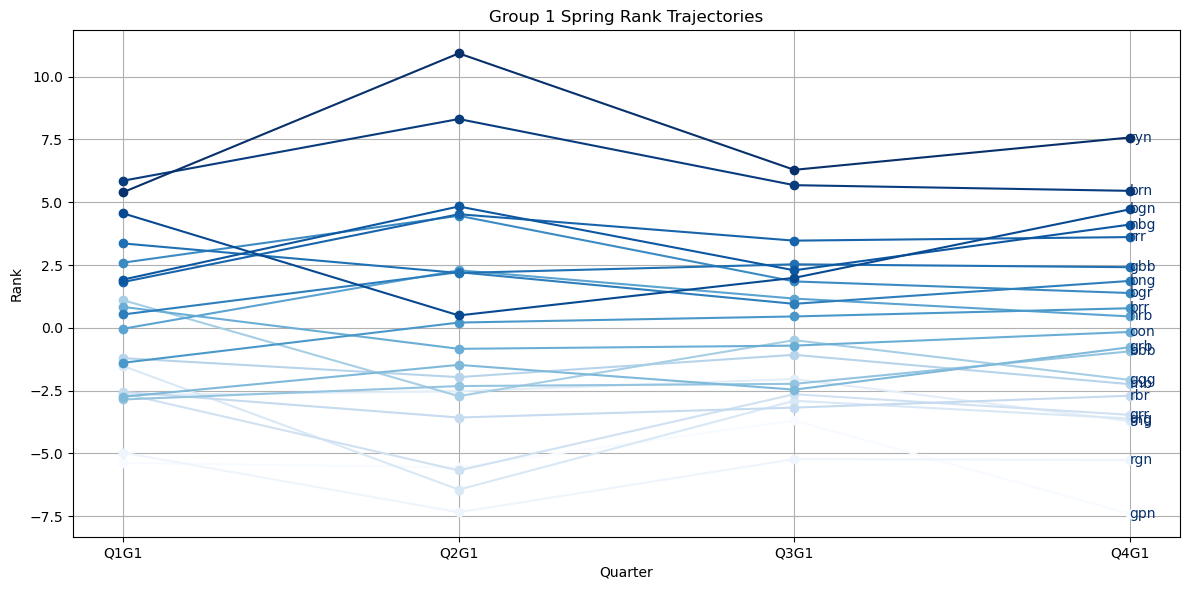

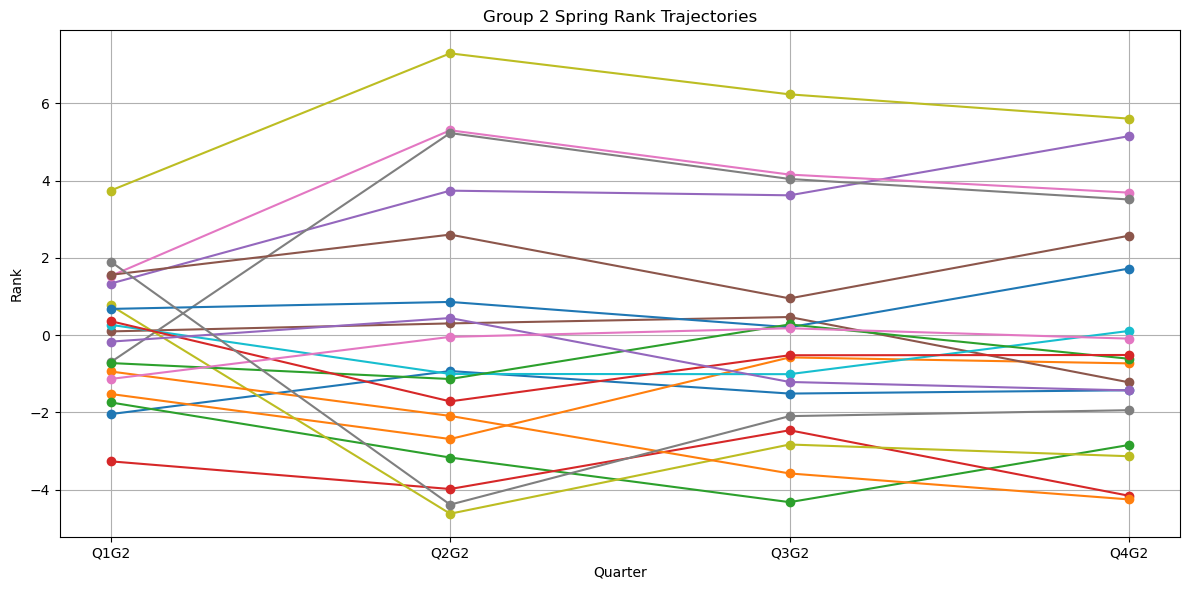

In [15]:
#plot spring rank trajectories (should make a function for this)
keys = sorted(rank_dict.keys())
group_1_keys = [name for name in keys if name.endswith("G1")]
group_2_keys = [name for name in keys if name.endswith("G2")]
group_1_values = [rank_dict[k] for k in group_1_keys]
group_2_values = [rank_dict[k] for k in group_2_keys]
group_1_nodes = list(group_1_values[0].keys())
group_2_nodes = list(group_2_values[0].keys())
#sort
final_key = group_1_keys[-1]
sorted_nodes = sorted(group_1_nodes, key = lambda n: rank_dict[final_key][n], reverse = False)
#color
colormap = plt.cm.Blues #Dr. Landry code to spectrum color it
colors = colormap(np.linspace(0, 1, len(group_1_nodes)))
plt.figure(figsize=(12,6))
for i, node in enumerate(sorted_nodes):
    color = colors[i]
    y = [rank_dict[k][node] for k in group_1_keys] 
    plt.plot(group_1_keys, y, marker = 'o', color = color, label = f"Index {node}")
    txt = plt.text(group_1_keys[-1], y[-1], f"{node}", fontsize=10, va = 'center', ha = 'left', color = line.get_color())
    texts.append(txt)
plt.xlabel("Quarter")
plt.ylabel("Rank")
plt.title("Group 1 Spring Rank Trajectories")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,6))
for node in group_2_nodes:
    y = [rank_dict[k][node] for k in group_2_keys] 
    plt.plot(group_2_keys, y, marker = 'o', label = f"Index {node}")
plt.xlabel("Quarter")
plt.ylabel("Rank")
plt.title("Group 2 Spring Rank Trajectories")
plt.grid(True)
plt.tight_layout()
plt.show()

#deeper hierarchy in q2 than q1 (then shallows a little again)
#as shown by increased range + stdev - this suggests skill is becoming more important than randomness bc the ranks are better established
#luck, skill, and depth of competition in games and social hierarchies doi10.1126


In [20]:
#set up a figure we can put each quarter's network on to compare
quarter_names = sorted(df_dict.keys())
group1 = [name for name in quarter_names if name.endswith("G1")]
group2 = [name for name in quarter_names if name.endswith("G2")]
def plot_by_group(names): 
    fig, ax = plt.subplots(2,2, figsize = (12,12))
    colors = ["red", "blue", "green", "yellow"]
    for i, name in enumerate(names):
        row = i // 2
        col = i % 2
        axis = ax[row][col]
#draw graphs for each quarter
        if name.startswith("Q1"):
            k = 0
        elif name.startswith("Q2"):
            k = 1
        elif name.startswith("Q3"):
            k = 2
        elif name.startswith("Q4"):
            k = 3
        axis.set_title(f"Quarter {k+1}")
        nx.draw(G_dict[name], ax = axis, with_labels=True, node_size=25, node_color=colors[k], font_size=20, edge_color='gray', alpha=0.6)
    plt.tight_layout()
    plt.show()

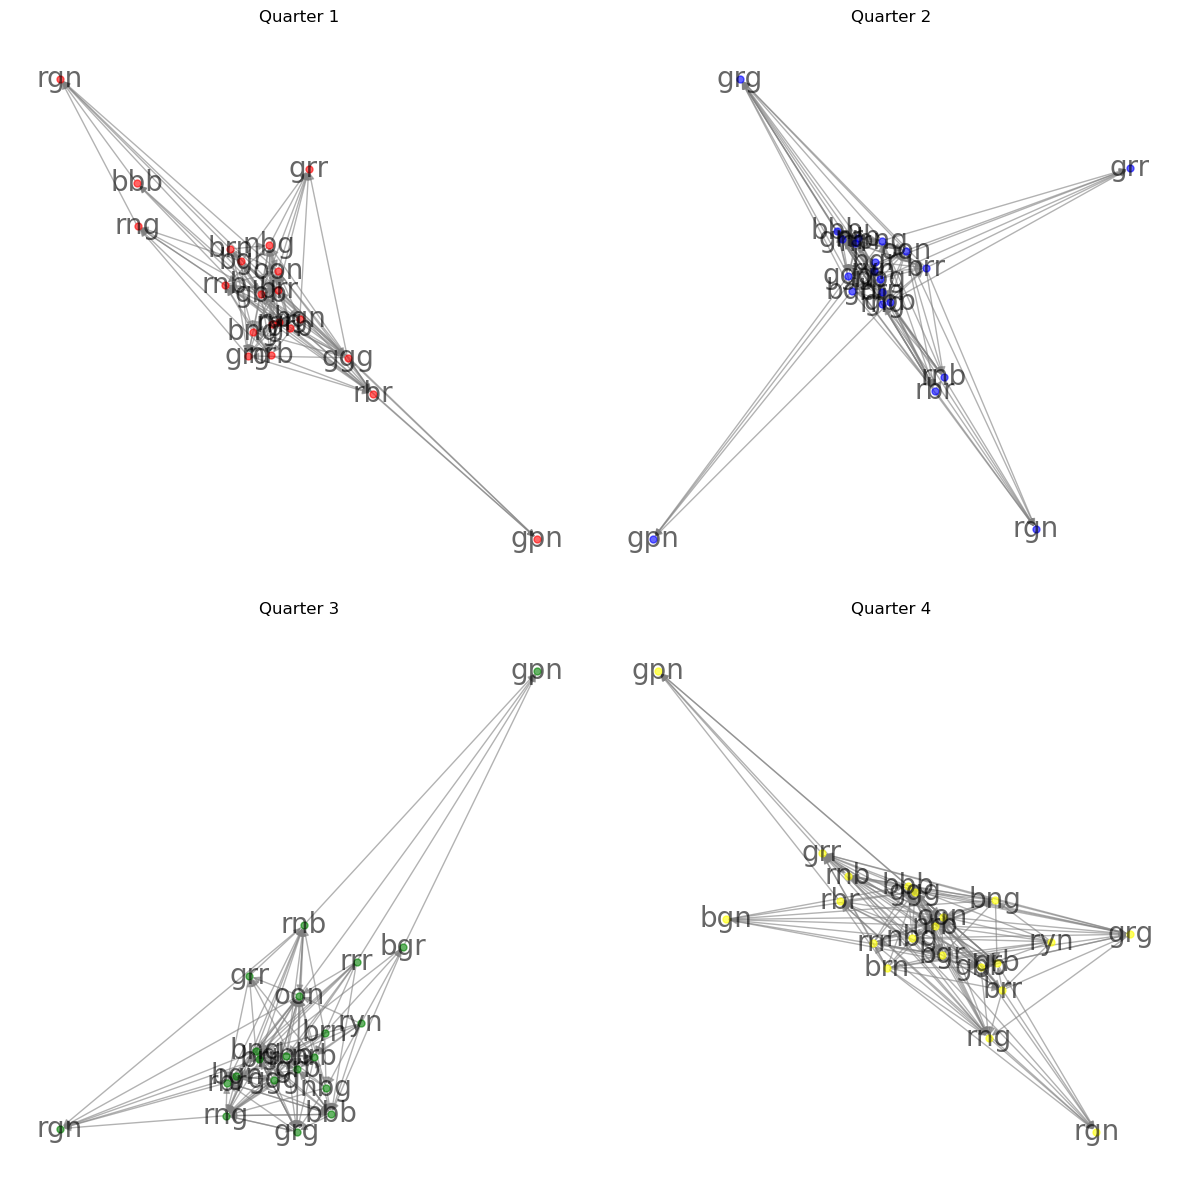

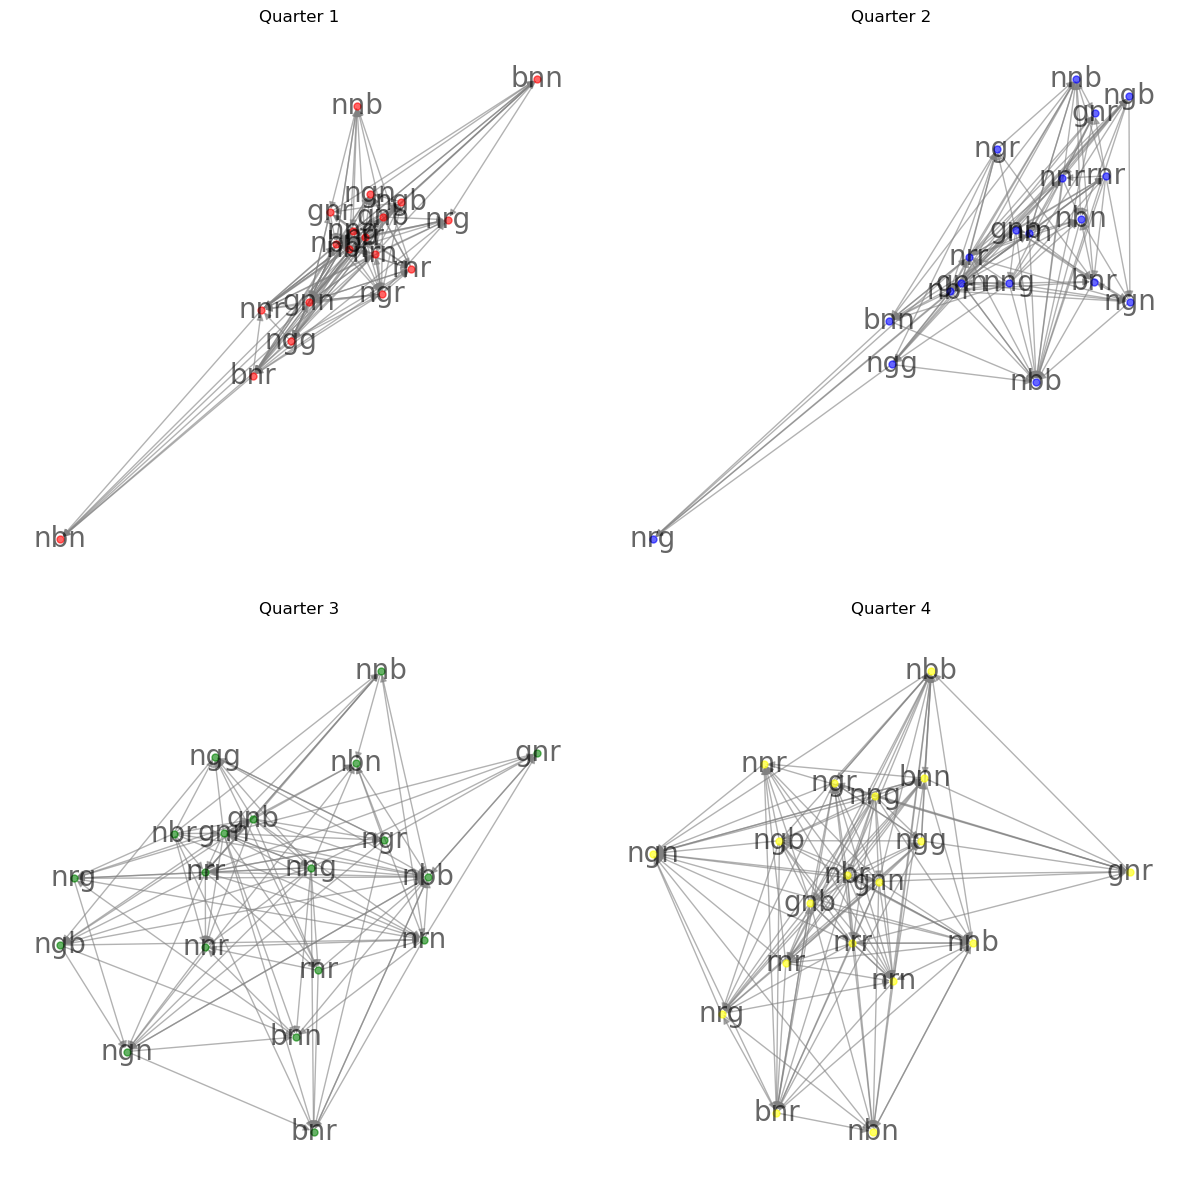

In [21]:
#call the function!
plot_by_group(group1)
plot_by_group(group2)

In [9]:
#plot rank swirl diagrams separated by group
quarter_names = sorted(df_dict.keys())
group1 = [name for name in quarter_names if name.endswith("G1")]
group2 = [name for name in quarter_names if name.endswith("G2")]
def rank_swirl_by_group(names): 
    fig, ax = plt.subplots(1,4, figsize = (12,12))
    for i, name in enumerate(names):
        #row = 1
        #col = i % 4
        axis = ax[i]
        svg_path = f"_swirl_{name}.svg"
        rank_swirl.nx2rankfigure(S_dict[name], G_dict[name], filepath = svg_path)

        png_bytes = cairosvg.svg2png(url=svg_path)
        img = Image.open(io.BytesIO(png_bytes))
        if name.startswith("Q1"):
            k = 0
        elif name.startswith("Q2"):
            k = 1
        elif name.startswith("Q3"):
            k = 2
        elif name.startswith("Q4"):
            k = 3
        axis.set_title(f"Quarter {k+1}")
        axis.imshow(img)
        axis.axis('off')
        #plt.close(swirl_fig)
    plt.tight_layout()
    plt.show()

In [19]:
print(len(group1))
print(len(group2))

4
4


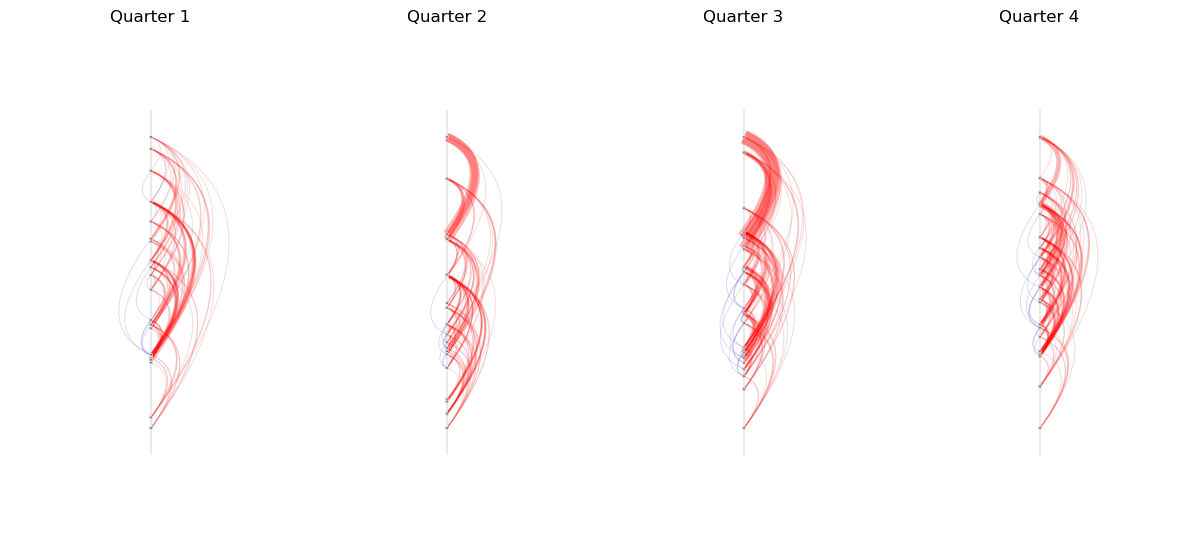

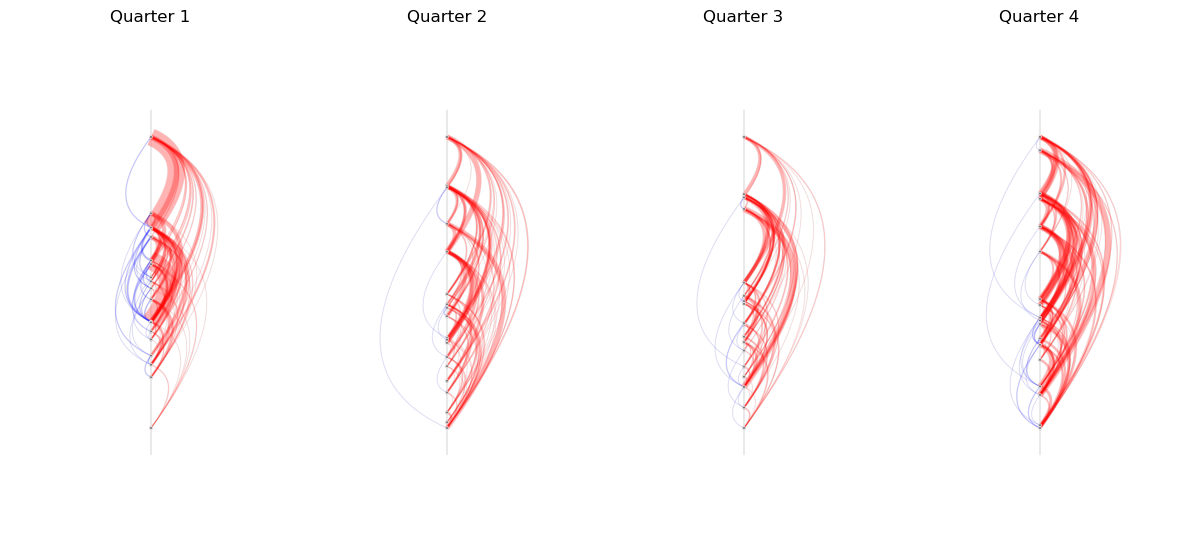

In [10]:
#call the function!
rank_swirl_by_group(group1)
rank_swirl_by_group(group2)

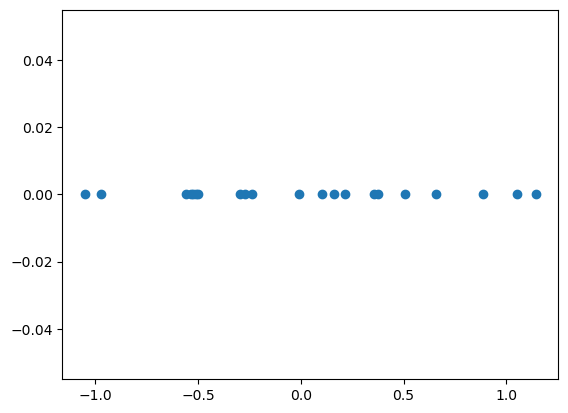

In [ ]:
#ordinal spring rankings (don't need this)
plt.plot(S, np.zeros(len(S)), "o")

In [ ]:
#not sure!
rank_swirl.nx2rankfigures(S, G)

AttributeError: 'str' object has no attribute 'nodes'

In [ ]:
for G in 
nx.eigenvector_centrality()